## Introduction

#### create a model to get an ideally functioning turbine’s expected rotor bearing temperature.

In [4]:
!pip install imbalanced-learn==0.7.0 -q
!pip install --user pycaret[full] -q
!pip install numba==0.53 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hypertools 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stumpy 1.11.1 requires numba>=0.54, but you have numba 0.53.0 which is incompatible.
hypertools 0.8.0 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
cudf 21.10.1 requires numba>=0.53.1, but you have numba 0.53.0 which is incompatible.


In [5]:
import pycaret
from pycaret.regression import *

In [6]:
!pip install metpy -q

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import re
#import klib

from scipy.stats import skew, kurtosis
from prettytable import PrettyTable
#import umap
import math
import metpy.calc as mpcalc
from sklearn.neighbors import KNeighborsRegressor

### Import train and test dataset

In [20]:
train=pd.read_csv("../input/renew-data-machinehack/train.csv")
test=pd.read_csv("../input/renew-data-machinehack/test.csv")

### Data pre-processing function

In [21]:
def pre_process(df):
    
    #change column names to lowercase
    df=df.rename(columns={col:col.lower()   for col in df.columns.values})
    
    #calculate tip ratio
    df['tip_ratio']=df['generator_speed']/df['wind_speed_raw']
    
    #convert angle to direction
    df['cardinal_direction']=mpcalc.angle_to_direction(df['wind_direction_raw'], full=True)
    
    #check active power that is calculated by the converter is greater than raw active power
    df['active-convert_pwr_grt_apwer']=(df['active_power_calculated_by_converter']>df['active_power_raw']).astype('int')
    
    #check reactive power that is calculated by the converter is greater than raw reactive power
    df['reactive-convert_pwr_grt_reapwer']=(df['reactice_power_calculated_by_converter']>df['reactive_power']).astype('int')
    
    #check nacelle inside temperature greater than nacelle temperature
    df['in_tmp_grt_out_tmp']=(df['nc1_inside_temp']>df['nacelle_temp']).astype('int')
    
    #calculate apparent power
    df['apparent_power']=df.apply(lambda x: math.sqrt(x.active_power_raw**2+x.reactive_power**2), axis=1)
    
    
    
    
    """categorical columns list"""

    grpcol=['turbine_id','cardinal_direction']

    """numerical columns list"""
    numcols=['active_power_calculated_by_converter', 'active_power_raw',
               'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
               'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
               'reactice_power_calculated_by_converter', 'reactive_power',
               'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
                 'tip_ratio','apparent_power'
                   ]


    """group by numerical summary of each numerical column"""
    def feature_eng(df):
        for valcol in numcols:
            df1=(df.groupby(grpcol)[valcol].agg({'min','median','mean','max'}).reset_index())
            df1=(df1.rename(columns={c:valcol+'_'+c for c in df1.loc[:,df1.columns.str.
                                                match("(min|median|mean|max)")]}))
            df=pd.merge(df,df1,on=grpcol,how='left')
        return df  


    df=feature_eng(df)
    
    """"
    z-score outlier detection for numerical columns  
    def outlier_z(df,x):
        threshold = 3
        out=[]
        mean = np.mean(df[x])
        std = np.std(df[x])
        for i in df[x]:
            if ((i-mean)/std) > threshold:
                out.append(1)
            else:
                out.append(0)
        return out
    
    for col in ['active_power_calculated_by_converter', 'active_power_raw',
                   'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
                   'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
                   'reactice_power_calculated_by_converter', 'reactive_power',
                   'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
                           ]:
        df[f"{col}_outlier"]= outlier_z(df,col)
   
    for col in ['active_power_calculated_by_converter', 'active_power_raw',
                   'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
                   'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
                   'reactice_power_calculated_by_converter', 'reactive_power',
                   'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
                           ]:
        df[f"{col}_skewness"]=df.groupby('turbine_id')[col].transform(pd.Series.skew)
        df[f"{col}_kurtosis"]=df.groupby('turbine_id')[col].transform(pd.Series.kurt)
        
    
    for col in ['active_power_calculated_by_converter', 'active_power_raw',
                   'ambient_temperature', 'generator_speed', 'generator_winding_temp_max',
                   'grid_power10min_average', 'nc1_inside_temp', 'nacelle_temp',
                   'reactice_power_calculated_by_converter', 'reactive_power',
                   'wind_direction_raw', 'wind_speed_raw', 'wind_speed_turbulence',
                           ]:
        df[f"{col}_1_lag"]=df[col].shift(1,fill_value=0)
        
    """
    
    return df

### Apply pre-process steps to train function

In [22]:
train=pre_process(train)

In [37]:
for i,j in enumerate(train.columns.values):
    print(f"{i}_{j}")  

0_timestamp
1_active_power_calculated_by_converter
2_active_power_raw
3_ambient_temperature
4_generator_speed
5_generator_winding_temp_max
6_grid_power10min_average
7_nc1_inside_temp
8_nacelle_temp
9_reactice_power_calculated_by_converter
10_reactive_power
11_wind_direction_raw
12_wind_speed_raw
13_wind_speed_turbulence
14_turbine_id
15_target
16_tip_ratio
17_cardinal_direction
18_active-convert_pwr_grt_apwer
19_reactive-convert_pwr_grt_reapwer
20_in_tmp_grt_out_tmp
21_apparent_power
22_active_power_calculated_by_converter_min
23_active_power_calculated_by_converter_median
24_active_power_calculated_by_converter_max
25_active_power_calculated_by_converter_mean
26_active_power_raw_min
27_active_power_raw_median
28_active_power_raw_max
29_active_power_raw_mean
30_ambient_temperature_min
31_ambient_temperature_median
32_ambient_temperature_max
33_ambient_temperature_mean
34_generator_speed_min
35_generator_speed_median
36_generator_speed_max
37_generator_speed_mean
38_generator_winding_te

### Split predictor and response variable

In [24]:
X=train.iloc[:,np.r_[1:15,16:82]]
y=train['target']

### Creata a dataframe with selected variable

In [25]:
train1=pd.concat([X,y],axis=1)

### Setup a pycaret model

In [26]:
reg_pycaret = setup(data = train1,
                    data_split_shuffle=True,
                    fold_strategy="kfold",
                    fold_shuffle=True,
                    fold=5,
                    target = 'target', session_id=112,
                    use_gpu =True,
                    silent=True
                    ) 
set_config('seed', 123)

,Description,Value
0,session_id,112
1,Target,target
2,Original Data,"(909604, 81)"
3,Missing Values,False
4,Numeric Features,75
5,Categorical Features,5
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(636722, 101)"


### Compare multiple regression models and select the top 3 models based on the evaluation metric MAPE.

In [27]:
top3 = compare_models(sort = 'MAPE',n_select=3,exclude=['rf','dt','ada','et','huber','gbr','par'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8855,1.7207,1.3117,0.7486,0.0273,0.0190,3.8520
catboost,CatBoost Regressor,0.8869,1.7129,1.3088,0.7498,0.0272,0.0191,26.2020
lightgbm,Light Gradient Boosting Machine,0.9480,1.9353,1.3911,0.7173,0.0289,0.0204,9.0580
br,Bayesian Ridge,1.1740,2.8389,1.6849,0.5853,0.0347,0.0251,9.8880
omp,Orthogonal Matching Pursuit,1.2666,3.1716,1.7809,0.5367,0.0368,0.0271,0.8300
en,Elastic Net,1.3312,3.6257,1.9041,0.4703,0.0393,0.0285,0.6480
lasso,Lasso Regression,1.3675,3.8313,1.9574,0.4403,0.0404,0.0293,0.6000
knn,K Neighbors Regressor,1.3952,3.7906,1.9469,0.4463,0.0407,0.0301,3.3800
ridge,Ridge Regression,1.5145,4.1408,2.0324,0.3949,0.0423,0.0325,0.4040
lr,Linear Regression,1.5544,4.4717,2.0838,0.3470,0.0434,0.0334,1.0160


### Blend the top 3 models.

In [28]:
blender = blend_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8891,1.7142,1.3093,0.7482,0.0272,0.0191
1,0.8901,1.7258,1.3137,0.7478,0.0274,0.0191
2,0.8913,1.7385,1.3185,0.7440,0.0275,0.0192
3,0.8884,1.7293,1.3150,0.7480,0.0273,0.0191
4,0.8964,1.7481,1.3222,0.7476,0.0275,0.0192
Mean,0.8910,1.7312,1.3157,0.7471,0.0274,0.0191
Std,0.0029,0.0115,0.0044,0.0016,0.0001,0.0001


### Finalize the model

In [29]:
final = finalize_model(blender)

In [30]:
from sklearn import set_config
set_config(display="diagram")

In [31]:
final

VotingRegressor(estimators=[('xgboost',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=0,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=2...
                                           colsample_bytree=1.0, device='gpu',
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=112,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent='warn', subsample=1.0,
                                           subsample_for_bin=200000,
                                           subsample_freq=0))],
                n_jobs=1, verbose=False, weights=None)

### Model Residual Plot

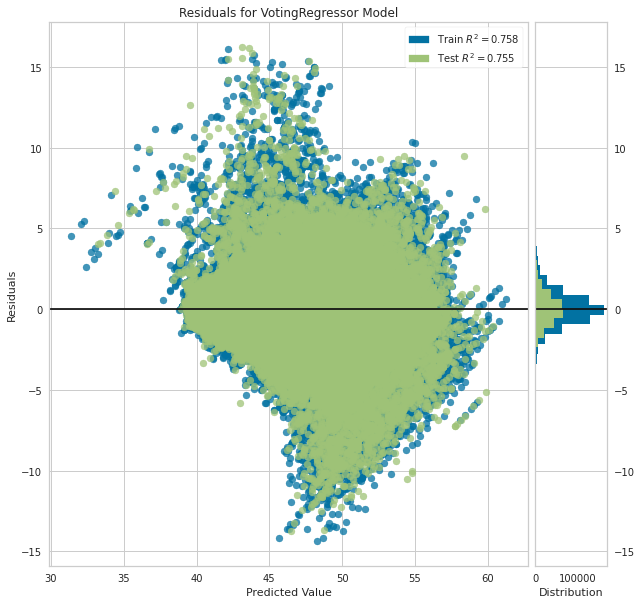

In [32]:
plt.figure(figsize = (10,10))
plot_model(final, plot = 'residuals')

### Error plot

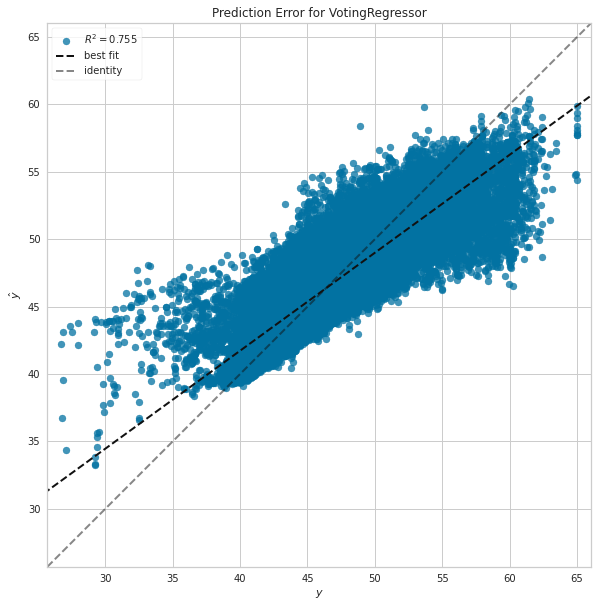

In [33]:
plt.figure(figsize = (10,10))
plot_model(final, plot = 'error')

### Xgboost model feature importance plot

<Figure size 720x720 with 0 Axes>

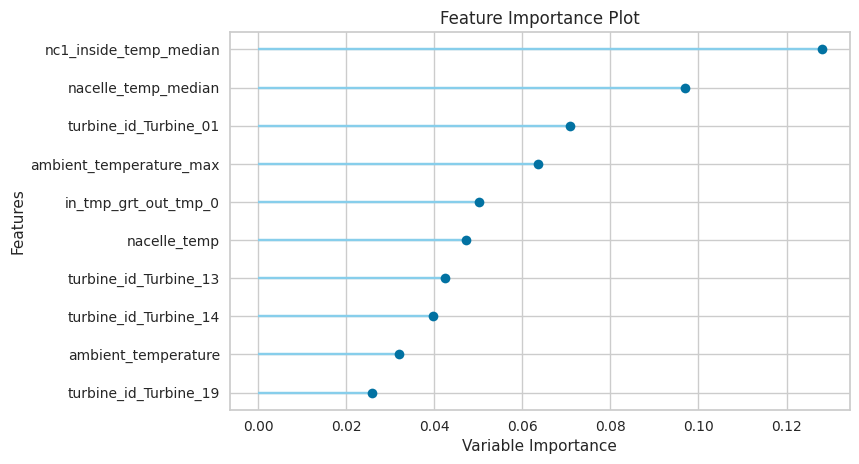

In [34]:
plt.figure(figsize = (10,10));
plot_model(final.named_estimators_[list(final.named_estimators)[0]], plot = 'feature');

### SHAP feature importance plot

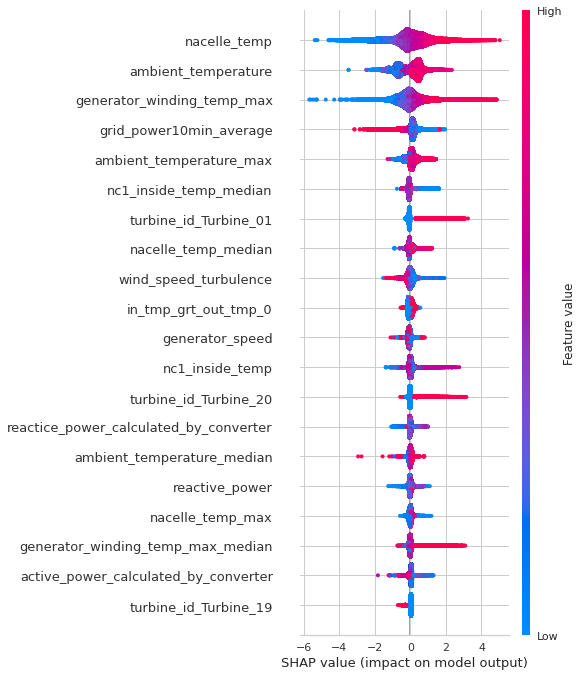

In [35]:
interpret_model(final.named_estimators_[list(final.named_estimators)[0]])

### Apply the pre-processing steps to test data

In [38]:
test=pre_process(test)

### Predict the new data

In [39]:
test['Target']=(predict_model(final, data=test.loc[:,X.columns])['Label'])

### Rotor bearing temperature of train and test data

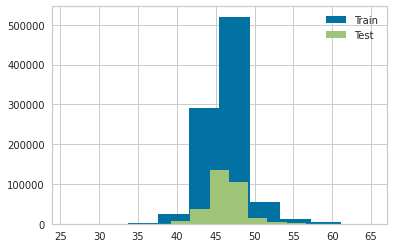

In [48]:
plt.figure(figsize=(6,4))
plt.hist(train['target'],label='Train');
plt.hist(test['Target'],label='Test');
plt.legend();

### Create result dataframe

In [40]:
res=pd.DataFrame({'Target':test['Target']})

### Write the dataframe to csv

In [20]:
res.to_csv("pycaret_blend.csv",index=False)